## CNN vs FC Layers

We pass this image in the actual form so we don't need to 'flatten' the image like with fully connected layers. It also can accept 2d and 3d inputs. Hence if we wanted to, we can input 3D printed models. The most typical is a 2D array.

The goal of a convolution is to locate the features of an image. The window of a convolution is called a **kernel**. After convoluting, the computer gets back numbers which are identified as features. The computer then does this thing called 'pooling' which is the same thing as a kernel. Of this pool, it finds the max value. 

**Conv + Pool = HL**  

The main concept is that it reduced the image to 'building blocks' and finds features according to those building blocks.

In [2]:
#!pip uninstall opencv-python
#!pip install opencv-contrib-python

  Using cached opencv_contrib_python-4.5.1.48-cp38-cp38-win_amd64.whl (41.2 MB)


In [22]:
import os
import cv2 as cv
import numpy as np
from tqdm import tqdm

In [23]:
REBUILD_DATA = False

class DogsVSCats():
    IMG_SIZE = 50
    CATS = 'PetImagesPC/Cat'
    DOGS = 'PetImagesPC/Dog'
    TESTING = 'PetImagesPC/Testing'
    LABELS = {CATS: 0, DOGS:1}
    training_data = []
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)): #tqdm gives a progress bar
                if 'jpg' in f:
                    try:
                        #print(label,f,str(e))
                        path = os.path.join(label,f)
                        img = cv.imread(path,cv.IMREAD_GRAYSCALE)
                        img = cv.resize(img, (self.IMG_SIZE,self.IMG_SIZE))
                        self.training_data.append([np.array(img),np.eye(2)[self.LABELS[label]]])

                        if label == self.CATS:
                            self.catcount+=1
                        elif label ==self.DOGS:
                            self.dogcount +=1

                    except Exception as e:
                        pass
                        #print(str(e))
                    
        np.random.shuffle(self.training_data)
        np.save('training_data.npy',self.training_data)
        print('Cats: ',self.catcount)
        print('Dogs: ',self.dogcount)
            
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()


  1%|          | 83/12501 [00:00<00:14, 829.80it/s]

PetImagesPC/Cat


  1%|▏         | 159/12501 [00:00<00:16, 763.11it/s]

PetImagesPC/Dog


100%|██████████| 12501/12501 [00:15<00:00, 787.63it/s]
C:\Users\Syazwan\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Cats:  12476
Dogs:  12470


`np.eye(2)[self.LABELS[label]]` creates a one_hot array with 2 possible outcomes. By passing the index of the outcome, we can get the corresponding one_hot array.

In [24]:
training_data = np.load('training_data.npy', allow_pickle = True)

In [25]:
print(len(training_data))
print(training_data[0])

24946
[array([[216, 200, 148, ...,  79,  83,  82],
       [219, 196,  99, ...,  77,  80,  75],
       [216, 187,  94, ..., 108, 108,  90],
       ...,
       [ 45,  51,  44, ..., 112, 154, 177],
       [ 44,  54,  50, ..., 155, 142, 102],
       [ 45,  54,  54, ..., 157, 191, 149]], dtype=uint8)
 array([0., 1.])]


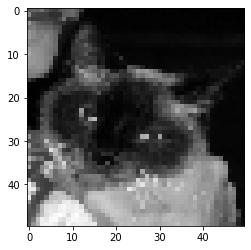

In [40]:
import matplotlib.pyplot as plt

plt.imshow(training_data[1][0], cmap = 'gray')
plt.show()

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5) #1 is input, 32 is no of features, 5 is kernel size
        self.conv2 = nn.Conv2d(32, 64, 5) #1 is input, 32 is no of features, 5 is kernel size
        self.conv3 = nn.Conv2d(64, 128, 5) #1 is input, 32 is no of features, 5 is kernel size
        
        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear,512)
        self.fc2 = nn.Linear(512,2)
    
    def convs(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)),(2,2))
        #print(x[0].shape)
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1,self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x,dim=1)
    
net = Net()

In [56]:
type(training_data[0][0])
x = [i[0] for i in training_data]

In [57]:
type(x)


list

In [58]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(),lr = 0.001)
loss_function= nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0 #normalise the data
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

2494


In [59]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_Y = y[-val_size:]

print(len(train_X))
print(len(test_X))
print(len(X))
print(train_y.shape)
print(train_X.shape)

22452
2494
24946
torch.Size([22452, 2])
torch.Size([22452, 50, 50])


In [68]:
BATCH_SIZE = 100 #if memory limit hit, lower the batch size.
EPOCHS = 3 #epochs is a full run over the data

for epoch in range(EPOCHS):
    for i in tqdm(range(0,len(train_X), BATCH_SIZE)): #start from 0, end at len(train_X), step is BATCH_SIZE
        #print(i, i+BATCH_SIZE)
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
        batch_y = train_y[i:i+BATCH_SIZE]
        #print('batch_y shape:',batch_y.shape)
        
        net.zero_grad()
        outputs = net(batch_X) #now we have outputs then we can calculate loss
        #print('outputs shape:',outputs.shape)
        loss = loss_function(outputs,batch_y)
        loss.backward()
        optimizer.step()
        
    print(loss)

  0%|          | 0/225 [00:00<?, ?it/s]

tensor(0.2498, grad_fn=<MseLossBackward>)


  0%|          | 0/225 [00:00<?, ?it/s]

tensor(0.2498, grad_fn=<MseLossBackward>)


100%|██████████| 225/225 [00:49<00:00,  4.56it/s]

tensor(0.2498, grad_fn=<MseLossBackward>)


In [69]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_Y[i])
        net_out = net(test_X[i].view(-1,1,50,50))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct+=1
        total+=1
print('Accuracy:',round(correct/total,3))

100%|██████████| 2494/2494 [00:04<00:00, 539.47it/s]

Accuracy: 0.505
